# Valuación de opciones con barrera

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    if freq == None:
        freq = 'd'
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [5]:
closes = get_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     60.172
2017-01-04     59.902
2017-01-05     59.902
2017-01-06     60.422
2017-01-09     60.229
               ...   
2018-11-12    106.410
2018-11-13    106.480
2018-11-14    104.970
2018-11-15    107.280
2018-11-16    108.290
Name: MSFT, Length: 474, dtype: float64

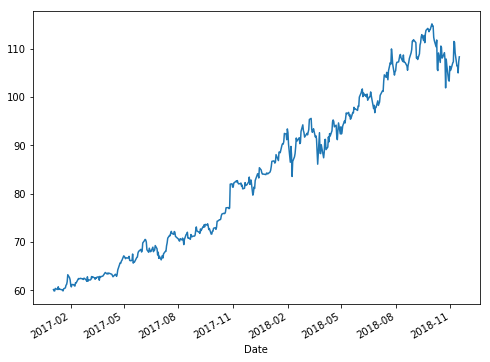

In [7]:
closes_msft.plot(figsize=(8,6));

In [12]:
closes_msft.iloc[-1]

108.29000091552734

## Calculamos rendimientos

In [8]:
ret_msft = calc_daily_ret(closes_msft)

## Descargamos datos de opciones para poder valuarlos



In [9]:
msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2018-11-23,99.0,call,MSFT181123C00099000,...,2018-11-16 21:00:01,2018-11-15 17:29:34,"{'contractSymbol': 'MSFT181123C00099000', 'str..."
2018-11-23,87.5,put,MSFT181123P00087500,...,2018-11-16 21:00:01,2018-11-01 18:33:35,"{'contractSymbol': 'MSFT181123P00087500', 'str..."
2018-11-23,113.0,put,MSFT181123P00113000,...,2018-11-16 21:00:01,2018-11-16 20:26:47,"{'contractSymbol': 'MSFT181123P00113000', 'str..."
2018-11-23,113.0,call,MSFT181123C00113000,...,2018-11-16 21:00:01,2018-11-16 20:47:41,"{'contractSymbol': 'MSFT181123C00113000', 'str..."
2018-11-23,88.5,put,MSFT181123P00088500,...,2018-11-16 21:00:01,2018-11-14 19:02:07,"{'contractSymbol': 'MSFT181123P00088500', 'str..."
...,...,...,...,...,...,...,...
2021-01-15,95.0,call,MSFT210115C00095000,...,2018-11-16 21:00:01,2018-11-14 20:09:28,"{'contractSymbol': 'MSFT210115C00095000', 'str..."
2021-01-15,95.0,put,MSFT210115P00095000,...,2018-11-16 21:00:01,2018-11-15 19:00:17,"{'contractSymbol': 'MSFT210115P00095000', 'str..."
2021-01-15,135.0,call,MSFT210115C00135000,...,2018-11-16 21:00:01,2018-11-16 14:30:53,"{'contractSymbol': 'MSFT210115C00135000', 'str..."


In [16]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Strike==108) & (msft_opt.Expiry=='2018-12-28')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
370,108.0,2018-12-28,call,...,2018-11-16 21:00:01,2018-11-16 20:55:09,"{'contractSymbol': 'MSFT181228C00108000', 'str..."


In [17]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            108
Expiry                                            2018-12-28 00:00:00
Type                                                             call
Symbol                                            MSFT181228C00108000
Last                                                             4.16
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  108
Quote_Time                                        2018-11-16 21:00:01
Last_Trade_Date                                   2018-11-16 20:55:09
JSON                {'contractSymbol': 'MSFT181228C00108000', 'str...
Name: 370, Length: 19, dtype: object

In [18]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT181228C00108000',
 'strike': 108.0,
 'currency': 'USD',
 'lastPrice': 4.16,
 'change': 0.19999981,
 'percentChange': 5.0505,
 'volume': 403,
 'openInterest': 159,
 'bid': 4.0,
 'ask': 4.25,
 'contractSize': 'REGULAR',
 'expiration': 1545955200,
 'lastTradeDate': 1542401709,
 'impliedVolatility': 0.28040270385742183,
 'inTheMoney': True}

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [20]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0272/360
mu, sigma, r

(0.0012423113893574164, 0.013187830351820222, 7.555555555555556e-05)

In [22]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

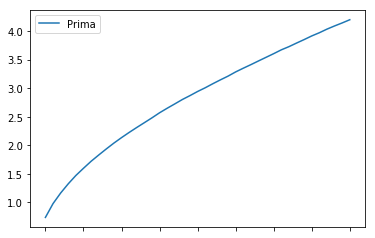

In [23]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call.plot();

In [24]:
call.iloc[-1]

Prima    4.199
Name: 2018-12-27, dtype: float64

In [25]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(4.141413655741377, 4.255700500253952)


### 1.2 Histograma de rendimientos

In [27]:
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [29]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

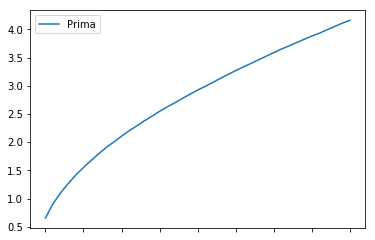

In [30]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [31]:
call_hist.iloc[-1]

Prima    4.158
Name: 2018-12-27, dtype: float64

In [32]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(4.10147190749619, 4.215405632065583)


In [33]:
opt_valuar['JSON']['lastPrice']

4.16

## 3. Valuación de una opción CALL down and out

### 3.1 Modelo normal de rendimientos

In [47]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0208/360
mu, sigma, r

(0.0012423113893574164, 0.013187830351820222, 5.7777777777777776e-05)

In [48]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

In [101]:
B = 105    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-11-17,False,False,False,...,False,False,False
2018-11-18,False,False,False,...,False,False,False
2018-11-19,False,False,False,...,False,False,False
2018-11-20,True,False,False,...,False,False,False
2018-11-21,True,False,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-12-23,True,False,True,...,True,False,False
2018-12-24,True,False,True,...,True,False,False
2018-12-25,True,False,True,...,True,False,False
2018-12-26,True,False,True,...,True,False,False


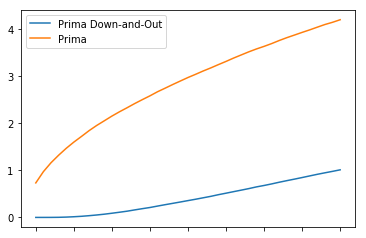

In [102]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima Down-and-Out':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = calldo.plot();
call.plot(ax=ax);

In [103]:
call.iloc[-1]

Prima    4.192
Name: 2018-12-27, dtype: float64

In [104]:
calldo.iloc[-1]

Prima Down-and-Out    1.009
Name: 2018-12-27, dtype: float64

### 3.2.-Histograma de rendimientos

In [41]:
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [42]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [57]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist<barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-11-17,True,True,True,...,False,True,True
2018-11-18,True,True,True,...,False,True,True
2018-11-19,True,True,True,...,False,True,True
2018-11-20,True,True,True,...,False,True,True
2018-11-21,True,True,True,...,False,True,True
...,...,...,...,...,...,...,...
2018-12-23,True,True,True,...,True,True,True
2018-12-24,True,True,True,...,True,True,True
2018-12-25,True,True,True,...,True,True,True
2018-12-26,True,True,True,...,True,True,True


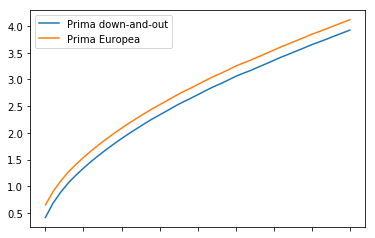

In [59]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = calldo.plot();
call.plot(ax=ax);

In [60]:
call.iloc[-1]

Prima Europea    4.118
Name: 2018-12-27, dtype: float64

In [61]:
calldo.iloc[-1]

Prima down-and-out    3.924
Name: 2018-12-27, dtype: float64

# 4.-Valuacion de una opcion PUT up and out

## 4.1Modelo normal de rendimientos

In [64]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='put') & (msft_opt.Strike==108) & (msft_opt.Expiry=='2018-12-28')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
371,108.0,2018-12-28,put,...,2018-11-16 21:00:01,2018-11-16 20:53:35,"{'contractSymbol': 'MSFT181228P00108000', 'str..."


In [65]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            108
Expiry                                            2018-12-28 00:00:00
Type                                                              put
Symbol                                            MSFT181228P00108000
Last                                                             3.45
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  108
Quote_Time                                        2018-11-16 21:00:01
Last_Trade_Date                                   2018-11-16 20:53:35
JSON                {'contractSymbol': 'MSFT181228P00108000', 'str...
Name: 371, Length: 19, dtype: object

In [66]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT181228P00108000',
 'strike': 108.0,
 'currency': 'USD',
 'lastPrice': 3.45,
 'change': -0.9799998,
 'percentChange': -22.121891,
 'volume': 10,
 'openInterest': 323,
 'bid': 3.4,
 'ask': 3.65,
 'contractSize': 'REGULAR',
 'expiration': 1545955200,
 'lastTradeDate': 1542401615,
 'impliedVolatility': 0.25928475097656256,
 'inTheMoney': False}

In [62]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0272/360
mu, sigma, r

(0.0012423113893574164, 0.013187830351820222, 7.555555555555556e-05)

In [67]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

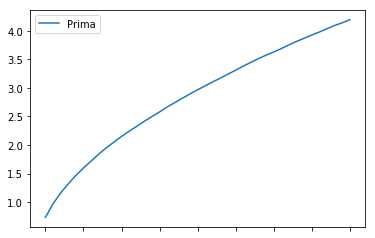

In [68]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call.plot();

In [69]:
call.iloc[-1]

Prima    4.192
Name: 2018-12-27, dtype: float64

In [70]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(4.135123896088204, 4.249550853090997)


In [97]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-11-17,False,False,False,...,False,False,False
2018-11-18,False,False,True,...,False,False,True
2018-11-19,False,False,True,...,False,False,True
2018-11-20,False,True,True,...,False,False,True
2018-11-21,False,True,True,...,False,False,True
...,...,...,...,...,...,...,...
2018-12-23,False,True,True,...,True,True,True
2018-12-24,False,True,True,...,True,True,True
2018-12-25,False,True,True,...,True,True,True
2018-12-26,False,True,True,...,True,True,True


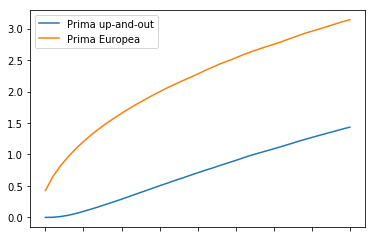

In [98]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)
putUO = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = putUO.plot();
put.plot(ax=ax);

In [99]:
put.iloc[-1]

Prima Europea    3.14
Name: 2018-12-27, dtype: float64

In [100]:
putUO.iloc[-1]

Prima up-and-out    1.433
Name: 2018-12-27, dtype: float64

### 4.2.-Histograma de rendimientos


In [87]:
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [88]:
K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ndays = (opt_valuar.Expiry.date()-datetime.today().date()).days
nscen = 100000
dates = pd.date_range(datetime.today().date(),periods=ndays).astype('str')

ret = np.random.choice(values[1:], (ndays,nscen), p = prob)
sim_ret_hist = pd.DataFrame(ret,index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [93]:
B = 110    # Precio barrera
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes_hist>barrier).cumsum()>0
I

,0,1,2,...,99997,99998,99999
2018-11-17,True,False,False,...,False,False,False
2018-11-18,True,False,False,...,False,False,False
2018-11-19,True,False,False,...,False,False,False
2018-11-20,True,True,False,...,False,False,False
2018-11-21,True,True,False,...,False,False,False
...,...,...,...,...,...,...,...
2018-12-23,True,True,False,...,False,True,False
2018-12-24,True,True,False,...,False,True,False
2018-12-25,True,True,False,...,False,True,False
2018-12-26,True,True,False,...,False,True,False


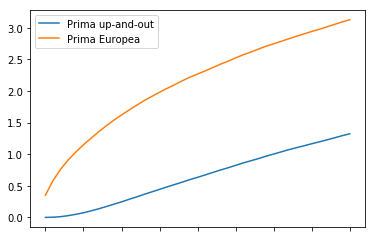

In [94]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros((ndays,nscen))).T.mean()},index=dates)
putUO = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes_hist,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax = putUO.plot();
put.plot(ax=ax);

In [95]:
put.iloc[-1]

Prima Europea    3.127
Name: 2018-12-27, dtype: float64

In [96]:
putUO.iloc[-1]

Prima up-and-out    1.323
Name: 2018-12-27, dtype: float64